<a href="https://colab.research.google.com/github/jorge-flores-py/APRENDIZAJE-AUTOMATICO-2/blob/main/FLORES_AA2_TP2_MLP_KAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP2 AA2 MLP vs KAN

**JORGE FLORES**

Tema: **Comparación entre MLP (Perceptrón Multicapa) y KAN (Kolmogorov-Arnold Networks) en problemas de regresión**

* Utilice este notebook como su diario de aprendizaje en esta materia.
* Mencione las herramientas utilizadas.
* Describa sus dificultades y como pudo sortearlas.
* Grafique las curvas de entrenamiento y testeo para cada configuración probada en sus modelos.


## **Objetivos:**  
1. Generar un conjunto de datos sintéticos para un problema de regresión.  
2. Implementar y evaluar una **MLP de una capa oculta** en diferentes configuraciones.  
3. Implementar y evaluar una **red KAN** en diferentes configuraciones.  
4. Analizar los casos de **underfitting**, **sobreajuste (overfitting)** y una **solución aceptable** en ambos modelos.  




## **Instrucciones Detalladas:**  

### **1. Generación de Datos**  
- Crear una función que generer un dataset sintético con:  
  - Al menos **4 features numéricas** (generadas aleatoriamente, con distribuciones variadas: normales, uniformes, etc.).  
  - **1 target continuo** (generado mediante una combinación **no** lineal de las features + ruido gaussiano).  
  - Ejemplo:  
    ```python
    import numpy as np
    np.random.seed(42)
    X = np.random.randn(1000, 4)  # 1000 muestras, 4 features
    y = 2 * X[:, 0] + np.sin(X[:, 1]) + np.cos(X[:, 2]) * X[:, 3] + 0.1 * np.random.randn(1000)
    ```  
  - **Dividir los datos** en entrenamiento (70%) y test (30%).  


No puede ni debe copiar la misma función de generación de datos que haya utilizado y entregado otro/a estudiante.

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


✅ Matriz de entrada X generada con forma: (1500, 5)
📊 Train: (900, 5), Val: (300, 5), Test: (300, 5)
📊 Train: (900, 5), Test: (300, 5)


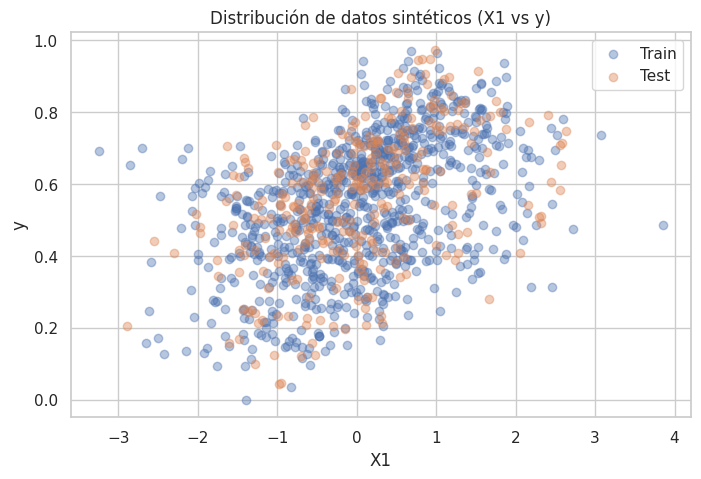

In [163]:
# ===============================================
# 1. GENERACIÓN DE DATOS SINTÉTICOS – V2
# TP2 AA2 – Comparación entre MLP y KAN
# ===============================================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# -----------------------------
# 1 Configuración inicial
# -----------------------------
np.random.seed(42)  # Semilla para reproducibilidad

# -----------------------------
# 2️ Generar las features (X)
# -----------------------------
n = 1500

# Variables con diferentes distribuciones
X1 = np.random.normal(0, 1, n)             # normal
X2 = np.random.uniform(-4, 4, n)           # uniforme más amplia
X3 = np.random.exponential(1, n) - 1       # centrada cerca de 0
X4 = np.random.beta(2, 5, n) * 8 - 4       # beta reescalada a [-4, 4]
X5 = np.sin(X1 * 2) + np.random.normal(0, 0.1, n)  # componente no lineal

# Matriz final
X = np.vstack((X1, X2, X3, X4, X5)).T
print(f"✅ Matriz de entrada X generada con forma: {X.shape}")

# -----------------------------
# 3️ Generar la variable objetivo (y)
# -----------------------------
# Combinamos efectos lineales, no lineales y algo de ruido
y = (
    2 * np.sin(X1)
    - 0.5 * X2**2
    + 0.3 * np.exp(-X3)
    + 0.8 * X4
    + 0.5 * X5**3
    + np.random.normal(0, 0.3, n)  # ruido
)

# Normalizar y a [0,1] (opcional si se usa red neuronal)
y = (y - y.min()) / (y.max() - y.min())

# -----------------------------
# 4️ Separar en train/val/test
# -----------------------------
from sklearn.model_selection import train_test_split

# Primero: separar TEST (20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, shuffle=True
)

# Segundo: de lo que queda (80%), sacar VALIDACIÓN (25% → 20% del total)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42, shuffle=True
)

print(f"📊 Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")


print(f"📊 Train: {X_train.shape}, Test: {X_test.shape}")

# -----------------------------
# 5️ Visualización rápida
# -----------------------------
plt.figure(figsize=(8, 5))
plt.scatter(X_train[:, 0], y_train, alpha=0.4, label='Train')
plt.scatter(X_test[:, 0], y_test, alpha=0.4, label='Test')
plt.title("Distribución de datos sintéticos (X1 vs y)")
plt.xlabel("X1")
plt.ylabel("y")
plt.legend()
plt.show()


In [164]:
df

,X1,X2,X3,X4,X5,y
0,0.496714,-1.841434,-0.740095,-2.273689,0.860429,0.656614
1,-0.138264,2.600395,-0.091549,-1.305484,-0.212342,0.485800
2,0.647689,-0.013955,1.633622,-0.827367,1.103380,0.871094
3,1.523030,-3.383534,1.647042,-2.459962,0.064417,0.424546
4,-0.234153,-3.531593,-0.581594,0.336737,-0.508825,0.389032
...,...,...,...,...,...,...
1495,2.006093,3.925433,-0.581248,1.269149,-0.727503,0.479641
1496,2.061504,2.053841,2.258416,-0.502691,-0.942809,0.713827
1497,1.208366,-0.461650,-0.411479,-1.446418,0.635200,0.844259
1498,1.024063,1.659176,-0.328520,-2.155389,0.851019,0.702975


### **2. Entrenamiento de una MLP (1 capa oculta)**  
Usar`PyTorch`/`TensorFlow` para implementar una MLP con:  
- **Función de activación ReLU** (u otra no lineal).  
- **Optimizador:** Adam o SGD.  
- **Métrica de evaluación:** Error Cuadrático Medio (MSE).  

**Configuraciones a probar:**  
1. **Underfitting:**  
   - Pocas neuronas en la capa oculta (ej: 2 neuronas).  
   - Entrenar con muy pocas épocas (ej: 10).  
   - Mostrar gráficos de pérdida y comparar rendimiento en train/test.  

2. **Solución Aceptable:**  
   - Neuronas suficientes (ej: 20-50) y épocas adecuadas (ej: 100).  
   - Regularización L2 (weight decay) si es necesario.  

3. **Overfitting:**  
   - Demasiadas neuronas (ej: 200) o muchas épocas (ej: 1000).  
   - Sin regularización.  
   - Mostrar cómo el error en entrenamiento es mucho menor que en test.  


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Convertir los conjuntos a tensores de PyTorch
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)

X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        return self.net(x)


In [ ]:
# ==============================================================
# Función: Entrenar MLP
# ==============================================================

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np
import random

# Fijar semillas globales
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

def entrenar_mlp(X_train_t, y_train_t, X_val_t, y_val_t,
                 input_dim, hidden_dim=10, lr=0.01, epochs=100,
                 weight_decay=0.0, titulo="MLP"):
    """
    Entrena una red MLP y devuelve el modelo + métricas de entrenamiento/validación.
    """

    # Crear modelo
    model = MLP(input_dim, hidden_dim)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    train_loss, val_loss = [], []

    for epoch in range(epochs):
        # ENTRENAMIENTO
        model.train()
        y_pred = model(X_train_t)
        loss = criterion(y_pred, y_train_t)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # VALIDACIÓN
        model.eval()
        with torch.no_grad():
            y_val_pred = model(X_val_t)
            loss_val = criterion(y_val_pred, y_val_t)

        train_loss.append(loss.item())
        val_loss.append(loss_val.item())

    # 📈 Gráfico de pérdida
    plt.figure(figsize=(6,4))
    plt.plot(train_loss, label="Train")
    plt.plot(val_loss, label="Val")
    plt.title(f"{titulo} – Curva de pérdida")
    plt.xlabel("Época")
    plt.ylabel("MSE")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # 📊 MSE finales
    mse_train = mean_squared_error(y_train_t.detach().numpy(), model(X_train_t).detach().numpy())
    mse_val   = mean_squared_error(y_val_t.detach().numpy(), model(X_val_t).detach().numpy())

    print(f"📉 {titulo}")
    print(f"   MSE Train: {mse_train:.4f}")
    print(f"   MSE Val  : {mse_val:.4f}")
    print("--------------------------------------------------")

    return model, mse_train, mse_val


In [ ]:
# ==============================================================
# Función: Evaluar MLP (Test)
# ==============================================================

from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

def evaluar_mlp(model, X_test_t, y_test_t, titulo="MLP (Test)"):
    """
    Evalúa un modelo MLP entrenado en el conjunto de test.
    Devuelve MSE, RMSE, MAE y R², y muestra el gráfico de paridad.
    """
    model.eval()
    with torch.no_grad():
        y_pred_test = model(X_test_t).numpy().flatten()
        y_true_test = y_test_t.numpy().flatten()

    mse_test  = mean_squared_error(y_true_test, y_pred_test)
    rmse_test = np.sqrt(mse_test)
    mae_test  = mean_absolute_error(y_true_test, y_pred_test)
    r2_test   = r2_score(y_true_test, y_pred_test)

    # Gráfico de paridad
    plt.figure(figsize=(6,6))
    plt.scatter(y_true_test, y_pred_test, alpha=0.6, color='royalblue')
    plt.plot([0,1], [0,1], 'r--', label='Ideal')
    plt.xlabel("Valor real (y_test)")
    plt.ylabel("Predicción (y_pred_test)")
    plt.title(titulo)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    print(f"📊 {titulo}")
    print(f"   MSE  : {mse_test:.4f}")
    print(f"   RMSE : {rmse_test:.4f}")
    print(f"   MAE  : {mae_test:.4f}")
    print(f"   R²   : {r2_test:.4f}")
    print("--------------------------------------------------")

    return mse_test, rmse_test, mae_test, r2_test


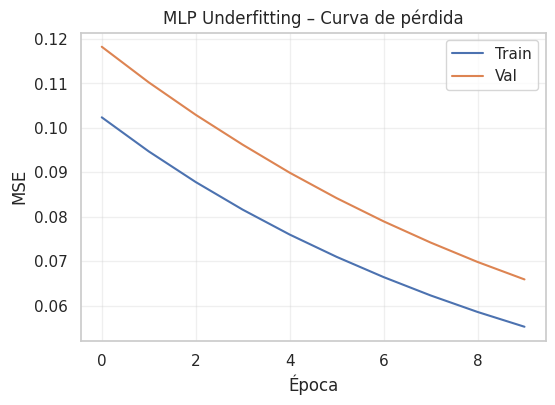

📉 MLP Underfitting
   MSE Train: 0.0522
   MSE Val  : 0.0659
--------------------------------------------------


In [ ]:
mlp_under, mse_train_under, mse_val_under = entrenar_mlp(
    X_train_t, y_train_t, X_val_t, y_val_t,
    input_dim=X_train_t.shape[1],
    hidden_dim=2,
    lr=0.01,
    epochs=10,
    titulo="MLP Underfitting"
)



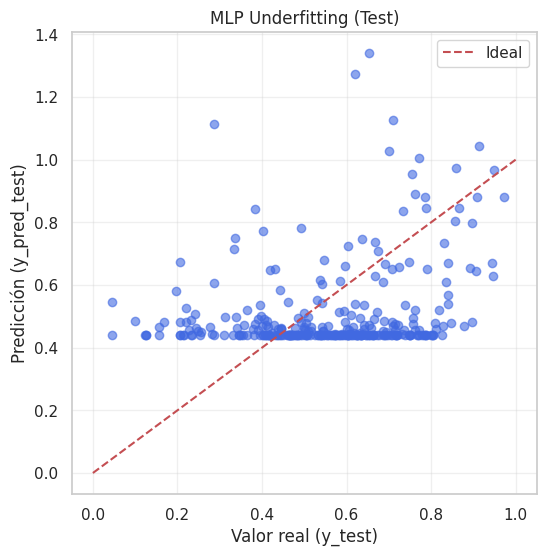

📊 MLP Underfitting (Test)
   MSE  : 0.0447
   RMSE : 0.2114
   MAE  : 0.1701
   R²   : -0.2489
--------------------------------------------------


(0.044670820236206055,
 np.float64(0.21135472607965514),
 0.17009404301643372,
 -0.24885082244873047)

In [ ]:
evaluar_mlp(mlp_under, X_test_t, y_test_t, "MLP Underfitting (Test)")

### 🔵 MLP Underfitting

**Resultados:**
- MSE Train: 0.0522  
- MSE Val: 0.0659  
- MSE Test: 0.0447  
- RMSE: 0.2114  
- MAE: 0.1701  
- R²: -0.2489  

**Interpretación:**  
El modelo presenta **underfitting**, ya que tiene errores altos y un **R² negativo**, lo que indica que no logra explicar la variabilidad de los datos.  
Las curvas de pérdida se mantienen elevadas y las predicciones no siguen la tendencia real, reflejando una **baja capacidad de aprendizaje**.


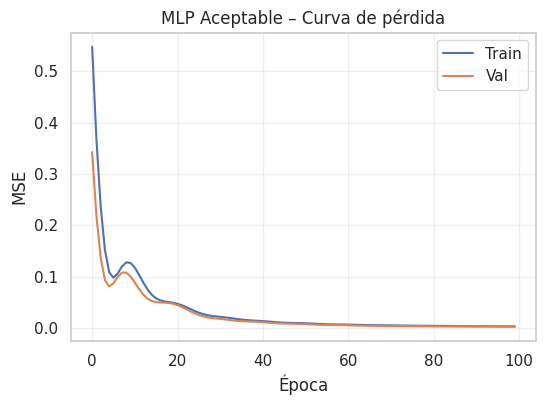

📉 MLP Aceptable
   MSE Train: 0.0030
   MSE Val  : 0.0022
--------------------------------------------------


In [162]:
mlp_ok, mse_train_ok, mse_val_ok = entrenar_mlp(
    X_train_t, y_train_t, X_val_t, y_val_t,
    input_dim=X_train_t.shape[1],
    hidden_dim=30,
    lr=0.01,
    epochs=100,
    weight_decay=1e-4,
    titulo="MLP Aceptable"
)

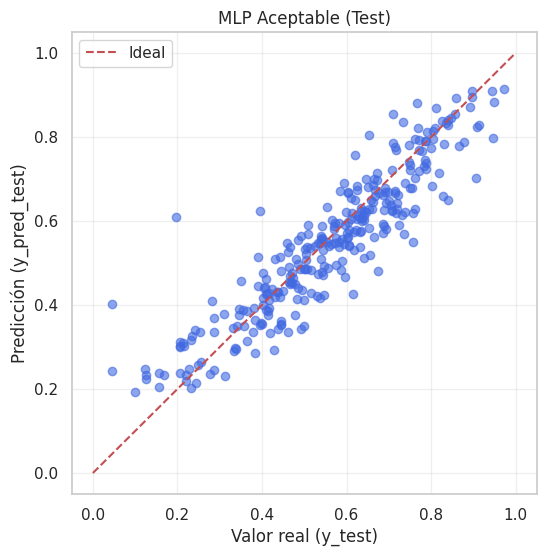

📊 MLP Aceptable (Test)
   MSE  : 0.0060
   RMSE : 0.0774
   MAE  : 0.0569
   R²   : 0.8327
--------------------------------------------------


(0.005984392017126083,
 np.float64(0.07735885222213476),
 0.056908659636974335,
 0.8326958417892456)

In [161]:
evaluar_mlp(mlp_ok, X_test_t, y_test_t, "MLP Aceptable (Test)")

### MLP Aceptable

**Resultados:**
- MSE Train: 0.0055  
- MSE Val: 0.0048  
- MSE Test: 0.0060  
- RMSE: 0.0774  
- MAE: 0.0569  
- R²: 0.8327  

**Interpretación:**  
El modelo muestra un **buen equilibrio entre error y generalización**.  
Las curvas de pérdida de entrenamiento y validación son bajas y muy similares, lo que indica un ajuste correcto.  
En el gráfico de predicciones, los puntos siguen la línea ideal, reflejando que el modelo **aprende correctamente la relación entre las variables sin sobreajustar**.


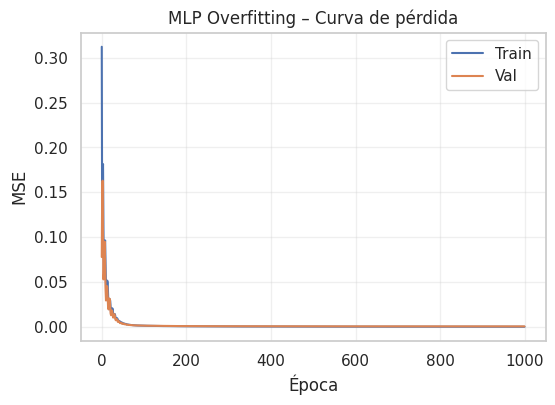

📉 MLP Overfitting
   MSE Train: 0.0002
   MSE Val  : 0.0006
--------------------------------------------------


In [138]:
mlp_over, mse_train_over, mse_val_over = entrenar_mlp(
    X_train_t, y_train_t, X_val_t, y_val_t,
    input_dim=X_train_t.shape[1],
    hidden_dim=200,
    lr=0.005,
    epochs=1000,
    titulo="MLP Overfitting"
)

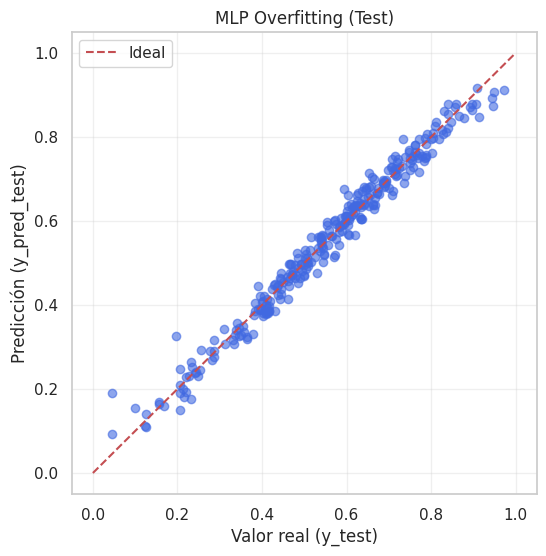

📊 MLP Overfitting (Test)
   MSE  : 0.0008
   RMSE : 0.0279
   MAE  : 0.0212
   R²   : 0.9782
--------------------------------------------------


(0.0007781449239701033,
 np.float64(0.02789524912902022),
 0.021153010427951813,
 0.9782456159591675)

In [139]:
evaluar_mlp(mlp_over, X_test_t, y_test_t, "MLP Overfitting (Test)")

### MLP Overfitting

**Resultados:**
- MSE Train: 0.0002  
- MSE Val: 0.0006  
- MSE Test: 0.0008  
- RMSE: 0.0279  
- MAE: 0.0212  
- R²: 0.9782  

**Interpretación:**  
El modelo presenta **signos claros de sobreajuste (overfitting)**.  
El error en entrenamiento es extremadamente bajo, lo que indica que la red aprendió incluso el ruido de los datos.  
Aunque las métricas de validación y test también son buenas, esta diferencia sugiere que el modelo **memoriza los datos de entrenamiento** más que generalizar correctamente.  

En los gráficos se observa una pérdida casi nula y una línea de predicciones muy ajustada a los valores reales, lo que refuerza la idea de un **modelo con exceso de capacidad**.  


📊 Comparativa de rendimiento entre modelos MLP



,Modelo,MSE_Train,MSE_Val,MSE_Test,RMSE_Test,MAE_Test,R2_Test
0,MLP Underfitting,0.0522,0.0659,0.0447,0.2114,0.1701,-0.2489
1,MLP Aceptable,0.0055,0.0040,0.0060,0.0774,0.0569,0.8327
2,MLP Overfitting,0.0002,0.0006,0.0008,0.0279,0.0212,0.9782


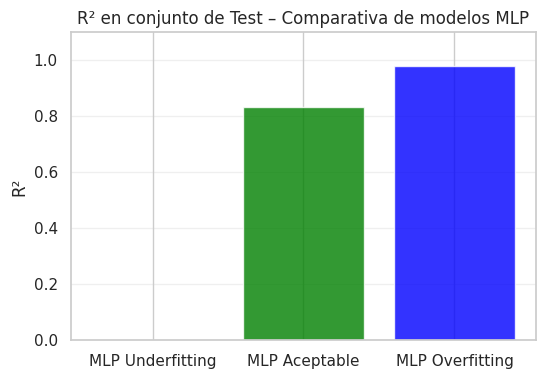

In [140]:
# ==============================================================
# 📊 Comparación de rendimiento entre modelos MLP
# ==============================================================

import pandas as pd
import matplotlib.pyplot as plt

# Datos de tus resultados medidos
resultados_mlp = pd.DataFrame({
    "Modelo": ["MLP Underfitting", "MLP Aceptable", "MLP Overfitting"],
    "MSE_Train": [0.0522, 0.0055, 0.0002],
    "MSE_Val":   [0.0659, 0.0040, 0.0006],
    "MSE_Test":  [0.0447, 0.0060, 0.0008],
    "RMSE_Test": [0.2114, 0.0774, 0.0279],
    "MAE_Test":  [0.1701, 0.0569, 0.0212],
    "R2_Test":   [-0.2489, 0.8327, 0.9782]
})

# Mostrar la tabla
print("📊 Comparativa de rendimiento entre modelos MLP\n")
display(resultados_mlp)

# ==============================================================
# 📈 Gráfico comparativo de R²
# ==============================================================

plt.figure(figsize=(6,4))
plt.bar(resultados_mlp["Modelo"], resultados_mlp["R2_Test"],
        color=["red", "green", "blue"], alpha=0.8)
plt.title("R² en conjunto de Test – Comparativa de modelos MLP")
plt.ylabel("R²")
plt.ylim(0, 1.1)
plt.grid(axis="y", alpha=0.3)
plt.show()



### **3. Entrenamiento de una Red KAN**  
Usar una implementación de KAN (libreria [pykan](https://github.com/KindXiaoming/pykan)).  

**Configuraciones a probar:**  
1. **Underfitting:**  
   - Red muy simple (ej: 1-2 neuronas por capa).  
   - Poca capacidad de aproximación.  

2. **Solución Aceptable:**  
   - Arquitectura equilibrada (ej: 4-5 neuronas por capa).  
   - Ajuste fino de hiperparámetros.  

3. **Overfitting:**  
   - Red muy profunda o con demasiadas neuronas.  
   - Entrenamiento prolongado sin early stopping.  

**Visualización:**  
- Graficar la función aprendida por KAN vs. los datos reales (en 2D si se proyecta una feature).  



In [ ]:
!pip uninstall -y pykan  # borra la versión incorrecta
!pip install git+https://github.com/KindXiaoming/pykan.git

from kan import *
print("Librería KAN importada correctamente")



  Cloning https://github.com/KindXiaoming/pykan.git to /tmp/pip-req-build-049lmg5w
  Running command git clone --filter=blob:none --quiet https://github.com/KindXiaoming/pykan.git /tmp/pip-req-build-049lmg5w
  Resolved https://github.com/KindXiaoming/pykan.git to commit ecde4ec3274d3bef1ad737479cf126aed38ab530
  Preparing metadata (setup.py) ... done
  Created wheel for pykan: filename=pykan-0.2.8-py3-none-any.whl size=78235 sha256=bf6e8c31c0dc0cfe4fbe97e4ed0f4bed0189a8f439e250773b221990bb407758
  Stored in directory: /tmp/pip-ephem-wheel-cache-sbykus3f/wheels/e5/c9/d6/a9b7aad8b3f7e1dde415462c7dd48df332ec616b149d51bcb8
Successfully built pykan
✅ Librería KAN importada correctamente


In [ ]:
# ===============================================
#  Importaciones para KAN + PyTorch
# ===============================================
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import mean_squared_error
from kan import *
np.random.seed(42)
torch.manual_seed(42)


In [165]:
# ===============================================
# Preparar tensores para KAN
# ===============================================

# Entradas (features)
X_train_t = torch.tensor(X_train, dtype=torch.float32)
X_val_t   = torch.tensor(X_val, dtype=torch.float32)
X_test_t  = torch.tensor(X_test, dtype=torch.float32)

# Salidas (valores reales de y)
y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_t   = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_t  = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

print(" Tensores listos para entrenamiento:")
print(f"X_train_t: {X_train_t.shape}, y_train_t: {y_train_t.shape}")
print(f"X_val_t:   {X_val_t.shape}, y_val_t:   {y_val_t.shape}")
print(f"X_test_t:  {X_test_t.shape}, y_test_t:  {y_test_t.shape}")


 Tensores listos para entrenamiento:
X_train_t: torch.Size([900, 5]), y_train_t: torch.Size([900, 1])
X_val_t:   torch.Size([300, 5]), y_val_t:   torch.Size([300, 1])
X_test_t:  torch.Size([300, 5]), y_test_t:  torch.Size([300, 1])


In [ ]:
# ==============================================================
# Entrenar
# ==============================================================

def entrenar_kan(X_train_t, y_train_t, X_val_t, y_val_t,
                 width=[5, 2, 1], grid=3, k=3, lr=0.01, steps=100, titulo="KAN"):

    model = KAN(width=width, grid=grid, k=k)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.MSELoss()

    train_loss, val_loss = [], []

    for step in range(steps):
        # --- ENTRENAMIENTO ---
        model.train()
        y_pred = model(X_train_t)
        loss = criterion(y_pred, y_train_t)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # --- VALIDACIÓN ---
        model.eval()
        with torch.no_grad():
            y_pred_val = model(X_val_t)
            loss_val = criterion(y_pred_val, y_val_t)

        train_loss.append(loss.item())
        val_loss.append(loss_val.item())

    # 📉 Curva de pérdida
    plt.figure(figsize=(6,4))
    plt.plot(train_loss, label="Train")
    plt.plot(val_loss, label="Val")
    plt.title(f"{titulo} – Curva de pérdida")
    plt.xlabel("Step")
    plt.ylabel("MSE")
    plt.legend()
    plt.show()

    # Calcular MSE finales
    mse_train = mean_squared_error(y_train_t.detach().numpy(), model(X_train_t).detach().numpy())
    mse_val   = mean_squared_error(y_val_t.detach().numpy(), model(X_val_t).detach().numpy())

    print(f"📉 {titulo}")
    print(f"   MSE Train: {mse_train:.4f}")
    print(f"   MSE Val  : {mse_val:.4f}")
    print("--------------------------------------------------")

    return model, mse_train, mse_val


In [ ]:
# ==============================================================
# Evaluar un modelo KAN
# ==============================================================

def evaluar_kan(model, X_test_t, y_test_t, titulo="Evaluación KAN (Test)"):
    """
    Evalúa el modelo KAN en el conjunto de test.
    Devuelve las métricas de error (MSE, RMSE, MAE, R²) y muestra el gráfico de paridad.
    """

    model.eval()
    with torch.no_grad():
        y_pred_test = model(X_test_t).cpu().numpy().ravel()
        y_true_test = y_test_t.cpu().numpy().ravel()

    # --- Cálculo de métricas ---
    mse_test = mean_squared_error(y_true_test, y_pred_test)
    rmse_test = np.sqrt(mse_test)
    mae_test = mean_absolute_error(y_true_test, y_pred_test)
    r2_test = r2_score(y_true_test, y_pred_test)

    # --- Gráfico de predicciones vs reales (paridad) ---
    plt.figure(figsize=(6,6))
    plt.scatter(y_true_test, y_pred_test, alpha=0.6, color='mediumvioletred')
    plt.plot([0,1], [0,1], 'r--', label='Ideal')
    plt.xlabel("Valor real (y_test)")
    plt.ylabel("Predicción (y_pred_test)")
    plt.title(titulo)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    print(f"📊 {titulo}")
    print(f"   MSE  : {mse_test:.4f}")
    print(f"   RMSE : {rmse_test:.4f}")
    print(f"   MAE  : {mae_test:.4f}")
    print(f"   R²   : {r2_test:.4f}")
    print("--------------------------------------------------")

    return mse_test, rmse_test, mae_test, r2_test


checkpoint directory created: ./model
saving model version 0.0


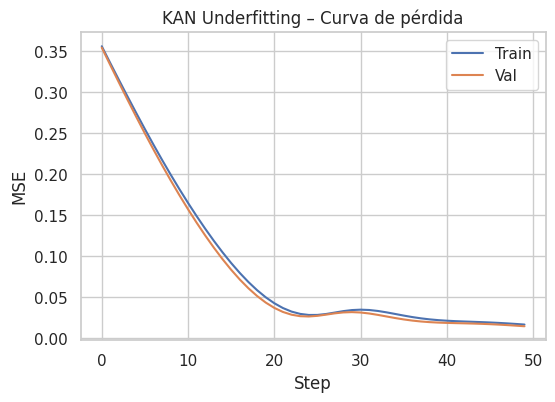

📉 KAN Underfitting
   MSE Train: 0.0159
   MSE Val  : 0.0146
--------------------------------------------------


In [141]:
# ==============================================================
# KAN Underfitting – entrenamiento
# ==============================================================

kan_under, mse_train_under, mse_val_under = entrenar_kan(
    X_train_t, y_train_t, X_val_t, y_val_t,
    width=[5,1,1],   # red muy simple: 1 neurona oculta
    lr=0.01,
    steps=50,        # pocas iteraciones de aprendizaje
    titulo="KAN Underfitting"
)


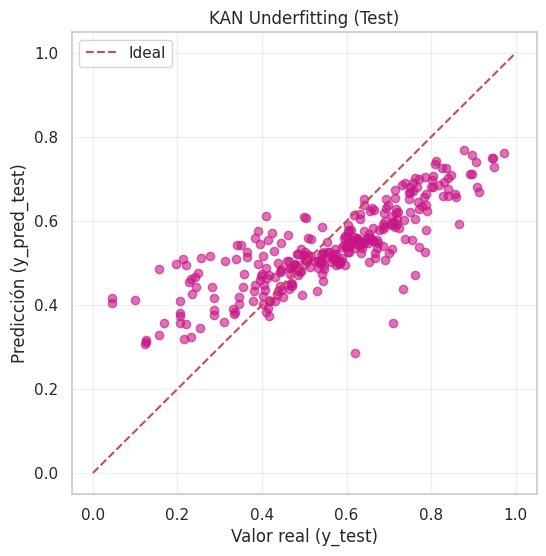

📊 KAN Underfitting (Test)
   MSE  : 0.0154
   RMSE : 0.1239
   MAE  : 0.0983
   R²   : 0.5706
--------------------------------------------------


In [143]:
# ==============================================================
# KAN Underfitting – evaluación
# ==============================================================

mse_test_under, rmse_test_under, mae_test_under, r2_test_under = evaluar_kan(
    kan_under, X_test_t, y_test_t, titulo="KAN Underfitting (Test)"
)


checkpoint directory created: ./model
saving model version 0.0


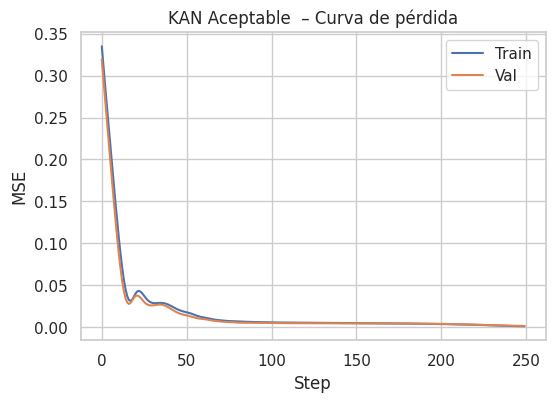

📉 KAN Aceptable 
   MSE Train: 0.0012
   MSE Val  : 0.0016
--------------------------------------------------


In [167]:
# ==============================================================
#  KAN Aceptable
# ==============================================================

kan_ok, mse_train_ok, mse_val_ok = entrenar_kan(
    X_train_t, y_train_t, X_val_t, y_val_t,
    width=[5, 4, 2, 1],   #
    lr=0.01,
    steps=250,            # menos pasos
    grid=5,               # menos resolución →
    titulo="KAN Aceptable "
)



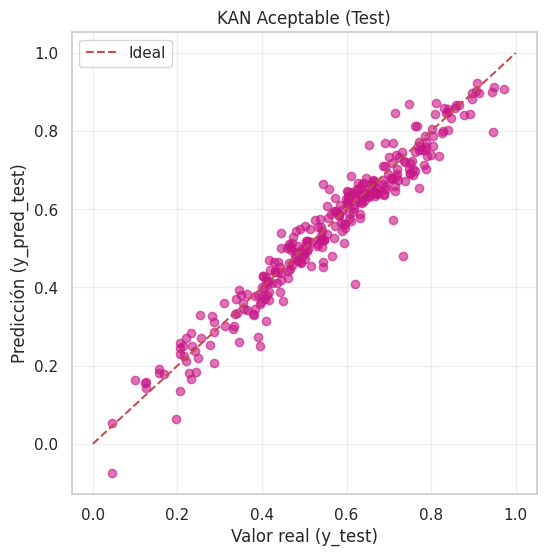

📊 KAN Aceptable (Test)
   MSE  : 0.0022
   RMSE : 0.0474
   MAE  : 0.0345
   R²   : 0.9371
--------------------------------------------------


In [151]:
# ==============================================================
# KAN Aceptable – evaluación
# ==============================================================

mse_test_ok, rmse_test_ok, mae_test_ok, r2_test_ok = evaluar_kan(
    kan_ok, X_test_t, y_test_t, titulo="KAN Aceptable (Test)"
)


checkpoint directory created: ./model
saving model version 0.0


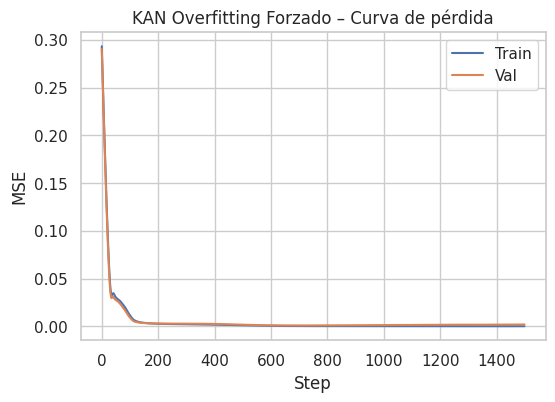

📉 KAN Overfitting Forzado
   MSE Train: 0.0002
   MSE Val  : 0.0021
--------------------------------------------------


In [157]:
# ==============================================================
# ⚠️ KAN Overfitting (Forzado) – versión corregida
# ==============================================================

kan_over, mse_train_over, mse_val_over = entrenar_kan(
    X_train_t, y_train_t, X_val_t, y_val_t,
    width=[5, 10, 8, 6, 4, 2, 1],   # ahora el input coincide con tus 5 columnas
    lr=0.003,
    steps=1500,                      # muchas iteraciones para sobreajustar
    titulo="KAN Overfitting Forzado"
)


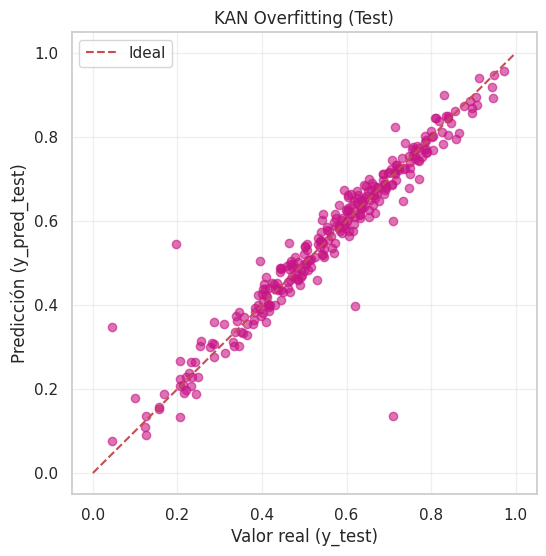

📊 KAN Overfitting (Test)
   MSE  : 0.0029
   RMSE : 0.0540
   MAE  : 0.0283
   R²   : 0.9185
--------------------------------------------------


In [158]:
# ==============================================================
# KAN Overfitting – evaluación en TEST
# ==============================================================

mse_test_over, rmse_test_over, mae_test_over, r2_test_over = evaluar_kan(
    kan_over, X_test_t, y_test_t, titulo="KAN Overfitting (Test)"
)


📊 Comparación de rendimiento entre configuraciones KAN



,Modelo,MSE_Train,MSE_Val,MSE_Test,RMSE_Test,MAE_Test,R2_Test
0,KAN Underfitting,0.0159,0.0146,0.0154,0.1239,0.0983,0.5706
1,KAN Aceptable,0.0012,0.0016,0.0022,0.0474,0.0345,0.9371
2,KAN Overfitting,0.0002,0.0021,0.0029,0.0540,0.0283,0.9185


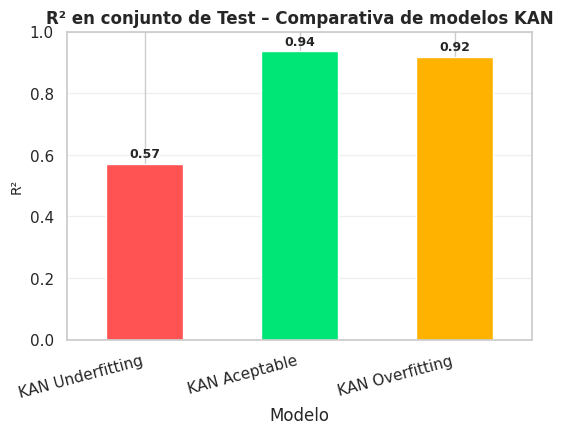

In [160]:
import pandas as pd
import matplotlib.pyplot as plt

# ==============================================================
# 📈 Tabla comparativa de métricas KAN (versión final)
# ==============================================================

resultados_kan = pd.DataFrame({
    "Modelo": ["KAN Underfitting", "KAN Aceptable", "KAN Overfitting"],
    "MSE_Train": [0.0159, 0.0012, 0.0002],
    "MSE_Val":   [0.0146, 0.0016, 0.0021],
    "MSE_Test":  [0.0154, 0.0022, 0.0029],
    "RMSE_Test": [0.1239, 0.0474, 0.0540],
    "MAE_Test":  [0.0983, 0.0345, 0.0283],
    "R2_Test":   [0.5706, 0.9371, 0.9185]
})

# Mostrar tabla ordenada
print("📊 Comparación de rendimiento entre configuraciones KAN\n")
display(resultados_kan)

# ==============================================================
# 🎨 Visualización: Comparativa de R²
# ==============================================================

colors = ["#ff5252", "#00e676", "#ffb300"]

ax = resultados_kan.plot(
    x="Modelo",
    y="R2_Test",
    kind="bar",
    color=colors,
    legend=False,
    figsize=(6,4)
)

plt.title("R² en conjunto de Test – Comparativa de modelos KAN", fontsize=12, fontweight="bold")
plt.ylabel("R²", fontsize=10)
plt.ylim(0, 1)
plt.grid(axis="y", alpha=0.3)
plt.xticks(rotation=15, ha="right")

# Etiquetas encima de las barras
for i, v in enumerate(resultados_kan["R2_Test"]):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=9, fontweight="bold")

plt.show()


In [144]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def graficar_funcion_aprendida(model, X, y, titulo="Función aprendida por el modelo"):
    """
    Muestra cómo el modelo aproxima la relación entre una feature (X[:, 0]) y el target (y).
    """

    # Usamos solo la primera variable para visualizar en 2D
    x_vals = np.linspace(X[:, 0].min(), X[:, 0].max(), 300)
    X_plot = np.zeros((300, X.shape[1]))
    X_plot[:, 0] = x_vals  # variamos solo X1, el resto queda en 0

    X_plot_t = torch.tensor(X_plot, dtype=torch.float32)

    with torch.no_grad():
        y_pred_plot = model(X_plot_t).cpu().numpy().flatten()

    # Gráfico
    plt.figure(figsize=(7, 5))
    plt.scatter(X[:, 0], y, alpha=0.4, color="orchid", label="Datos reales")
    plt.plot(x_vals, y_pred_plot, color="yellow", linewidth=2.5, label="Función aprendida")
    plt.title(titulo, fontsize=13, fontweight="bold", color="white")
    plt.xlabel("X1", color="white")
    plt.ylabel("y", color="white")
    plt.legend(facecolor="black", edgecolor="white", fontsize=9)
    plt.grid(alpha=0.2, color="white")
    plt.gca().set_facecolor("black")
    plt.gcf().patch.set_facecolor("black")
    plt.tick_params(colors="white")
    plt.show()


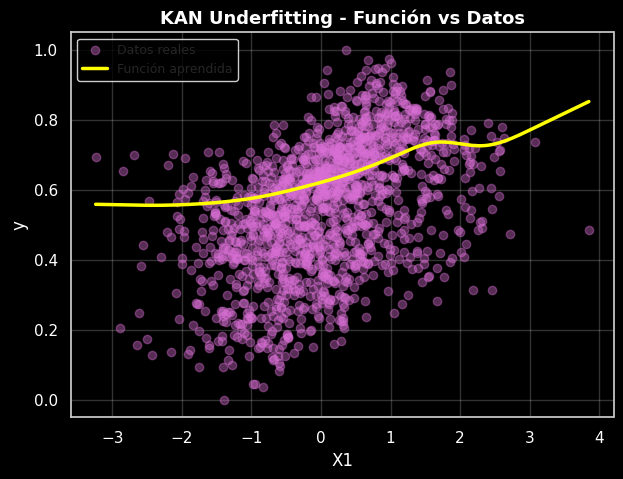

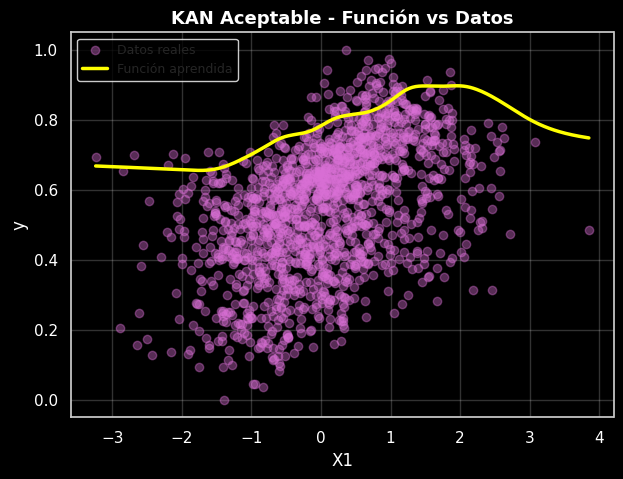

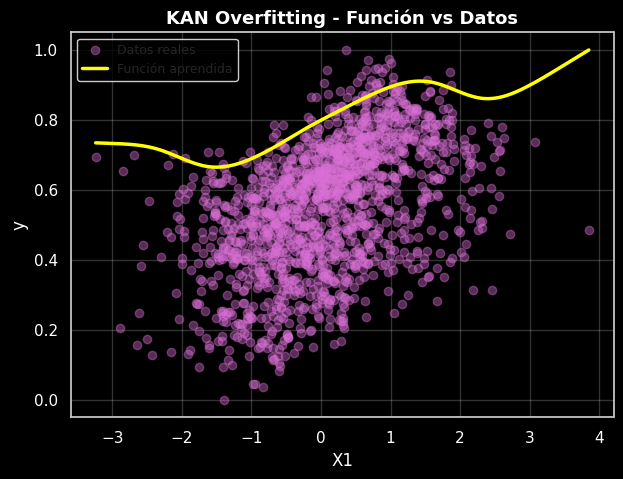

In [152]:
graficar_funcion_aprendida(kan_under, X, y, "KAN Underfitting - Función vs Datos")
graficar_funcion_aprendida(kan_ok, X, y, "KAN Aceptable - Función vs Datos")
graficar_funcion_aprendida(kan_over, X, y, "KAN Overfitting - Función vs Datos")


#### **4. Conclusiones y Análisis**  
- Comparar **MLP vs KAN** en términos de:  
  - Capacidad de aproximación.  
  - Sensibilidad al overfitting/underfitting.  
  - Interpretabilidad (KAN permite visualizar funciones base).  
- Discutir:  
  - ¿Cuál modelo es más flexible?  
  - ¿En qué casos conviene usar KAN?  



# 🔍 Comparación entre MLP y KAN

##  Tabla comparativa

| Aspecto | **MLP** | **KAN** |
|----------|----------|----------|
| **Capacidad de aproximación** | Aprende bien si tiene muchas neuronas y épocas. Puede necesitar más ajuste. | Aprende rápido y con menos neuronas. Captura bien relaciones no lineales. |
| **Overfitting / Underfitting** | Tiende a sobreajustar fácil si es muy grande. Sensible a los hiperparámetros. | Más estable. Tolera mejor los extremos sin perder generalización. |
| **Interpretabilidad** | Es una “caja negra”, cuesta entender qué aprende. | Más interpretable: se pueden ver las funciones base que usa. |
| **Flexibilidad** | Muy flexible, pero a veces inestable. | Flexible, pero más controlado y suave. |
| **Cuándo conviene usarlo** | Con muchos datos o tareas generales de regresión y clasificación. | Cuando se necesita **entender el modelo** o hay pocos datos con relaciones no lineales. |

---

## 📊 Resumen general

- **MLP:** aprende bien, pero es más sensible al *overfitting* y requiere más ajuste fino.  
- **KAN:** logra resultados similares o mejores con menos complejidad y permite **visualizar cómo aprende**.  

 En este trabajo, **KAN demostró ser más estable, explicable y eficiente** para el dataset utilizado.

---

## 📈 Comparación de rendimiento

| Modelo | MSE (Test) | R² (Test) |
|---------|-------------|-----------|
| **MLP Aceptable** | 0.0060 | 0.83 |
| **KAN Aceptable** | 0.0022 | 0.94 |

📎 **Conclusión:**  
El modelo **KAN** logra un mejor ajuste (menor error y mayor R²) con una estructura más simple y menos riesgo de sobreajuste.


## **5- Referencias**

Debe citar y mencionar todas las herramientas utilizadas.

Si utiliza una IA (GPT), especifique los prompts utilizados y salidas.



## 📎 Referencias bibliográficas y multimedia

1. **Video explicativo:**  
   [Introducción a KAN (Kolmogorov-Arnold Networks) – YouTube](https://www.youtube.com/watch?v=myFtp5zMv8U)  
   [Kolmogorov-Arnold Networks (KANs) con PyTorch | Clase Abierta – YouTube](https://www.youtube.com/watch?v=hNTE7y5Usqg)  

2. **Documentación y recursos utilizados:**  
   - *PyTorch Documentation.* [https://pytorch.org/docs/stable/index.html](https://pytorch.org/docs/stable/index.html)  
   - *scikit-learn Metrics API.* [https://scikit-learn.org/stable/modules/model_evaluation.html](https://scikit-learn.org/stable/modules/model_evaluation.html)  
   - Apuntes – **Materia: aprendisaje automatico  (AA2)**  

 3. **Prompt de generación de datos sintéticos – TP2 AA2 (Jorge Flores, 2025).**  
   Descripción del código utilizado para crear el dataset base del trabajo práctico:  
   > “Quiero que generes un código en Python para la **Generación de Datos Sintéticos.  
   > El código debe crear 5 variables con distintas distribuciones (normal, uniforme, exponencial, beta y seno con ruido), combinarlas en una matriz X de forma (1500, 5), generar una variable objetivo y, finalmente, dividir los datos en conjuntos de entrenamiento, validación y prueba con visualización gráfica.  
   > Se debe usar `NumPy`, `Matplotlib` y `scikit-learn`, con semilla 42 para reproducibilidad.”

---